In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from scipy.sparse import coo_matrix, find

from run_id import run_id
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)
print(q.id)

wos_all
365


In [2]:
kws = KW.objects.filter(doc__query=q,kwtype=0,doc__ipccref__isnull=False)
kws.count()

48591

In [3]:
tdf = pd.DataFrame.from_dict(list(kws[:10].values()))
tdf.head()

,id,kwtype,ndocs,text
0,316345,0,0,ph
1,366468,0,0,cumulative effects
2,309827,0,0,climate change
3,402720,0,0,carbonate chemistry
4,321841,0,0,calcification


In [4]:
kw_wg = kws.values('text','doc__ipccref__wg__wg').annotate(
    n = Count('id')
).order_by('-n')

df = pd.DataFrame.from_dict(list(kw_wg)).rename(index=str, columns={"doc__ipccref__wg__wg": "wg"})

df.head()

,wg,n,text
0,2.0,2606,climate change
1,2.0,609,adaptation
2,1.0,540,climate change
3,3.0,501,climate change
4,2.0,297,global warming


In [5]:
pdf = df.pivot('text','wg','n')

pdf.sort_values(1,ascending=False).head()



wg,nan,1.0,2.0,3.0
text,,,,
climate change,NaN,540.0,2606.0,501.0
global warming,NaN,88.0,297.0,85.0
climate,NaN,87.0,166.0,29.0
precipitation,NaN,86.0,79.0,1.0
carbon cycle,NaN,60.0,21.0,14.0


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


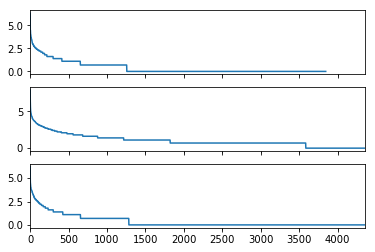

In [6]:
f, axs = plt.subplots(3, sharex=True)#, sharey=True)
plt.rcParams["figure.figsize"] = [16,10]
for wg in [1,2,3]:
    ax = axs[wg-1]
    wdf = df[(df['wg']==wg)]
    wdf['ln'] = np.log(wdf['n'])
    wdf = wdf.reset_index()
    wdf['ln'].plot.line(ax=ax)
    

plt.show()

In [7]:


kwmatrix = kws.filter(kwtype=0,doc__primary_topic__isnull=False).annotate(
    n = Count('id')
).filter(n__gt=1).values('id','doc__id').annotate(
    n = Count('doc__id',distinct=True)
).order_by('-n','-doc__primary_topic__score')

df = pd.DataFrame.from_dict(list(kwmatrix.values('doc__primary_topic__title','doc__id','id','n')))

df.head()


,doc__id,doc__primary_topic__title,id,n
0,9996,None,313162,1
1,282899,None,330012,1
2,268262,None,310157,1
3,9996,None,326674,1
4,40182,None,309827,1


In [8]:
df['doc'] = pd.Categorical(df['doc__id'],df['doc__id'].unique())

df['topic'] = pd.Categorical(df['doc__primary_topic__title'],df['doc__primary_topic__title'].unique())

print(df.sort_values('doc').head(10))

    doc__id doc__primary_topic__title      id  n     doc topic
0      9996                      None  313162  1    9996  None
68     9996                      None  316810  1    9996  None
39     9996                      None  317458  1    9996  None
35     9996                      None  316989  1    9996  None
53     9996                      None  326675  1    9996  None
3      9996                      None  326674  1    9996  None
52   282899                      None  312145  1  282899  None
62   282899                      None  312751  1  282899  None
1    282899                      None  330012  1  282899  None
24   282899                      None  309827  1  282899  None


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: FutureWarning: 
Setting NaNs in `categories` is deprecated and will be removed in a future version of pandas.
  app.launch_new_instance()


In [9]:
pdf = df.pivot('doc','id','topic')

pdf.head()

/usr/local/lib/python3.4/dist-packages/pandas/core/reshape.py:171: FutureWarning: 
Setting NaNs in `categories` is deprecated and will be removed in a future version of pandas.
  for i in range(values.shape[-1])]


id,309806,309807,309813,309814,309827,309833,309857,309859,309868,309869,...,754864,756181,756182,756456,756650,756651,757658,757659,757939,757940
doc,,,,,,,,,,,,,,,,,,,,,
9996,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
282899,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
268262,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
40182,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
14373,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [10]:
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = [16,10]
ax = sns.heatmap(pdf,xticklabels=False,yticklabels=False,cmap="Greys",square=True)

s= pdf.shape

ax.text(s[1]/2,s[0]*-0.25,"{} x {}".format(s[0], s[1]),ha="center",va="center")

plt.show()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [11]:
from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    ColorBar,
)
from bokeh.plotting import figure

docs = pd['doc']


source = ColumnDataSource(pdf)

p = figure()

ValueError: expected an element of List(String), got seq with invalid items [327682, 327683, 311304, 540684, 425997, 409615, 311299, 311318, 546137, 557080, 557081, 557082, 311323, 311328, 311329, 344098, 311331, 311332, 344104, 344105, 475178, 589874, 311349, 622646, 327736, 360507, 344125, 344127, 426048, 327746, 311364, 327749, 393287, 393288, 589897, 344138, 344139, 344140, 344143, 344146, 376915, 327764, 393302, 311383, 475224, 327770, 360539, 311388, 606309, 557158, 557159, 409707, 557167, 557168, 327794, 688251, 352278, 311430, 458889, 376976, 335896, 311442, 475284, 475285, 327830, 311447, 409756, 376992, 376993, 393378, 557083, 311460, 524453, 344230, 737449, 475306, 311469, 737456, 311475, 311476, 344245, 344246, 344250, 311487, 327872, 327873, 458785, 458786, 344270, 753872, 753873, 442583, 311512, 311513, 475359, 311527, 540904, 360681, 311530, 311533, 311534, 409842, 540917, 704768, 311553, 557315, 311563, 344332, 311565, 311566, 344335, 314072, 442642, 311573, 344345, 344346, 344347, 327972, 426282, 426283, 426284, 426285, 311598, 426287, 426288, 426289, 426290, 338654, 360758, 311608, 416920, 360764, 426037, 330394, 328002, 328003, 344393, 439693, 622648, 328024, 344409, 415119, 330676, 349584, 426043, 350580, 328040, 377193, 333202, 311664, 690574, 393586, 393587, 393588, 393589, 344444, 311677, 311679, 311680, 415126, 475531, 311694, 311696, 508305, 410006, 328087, 688536, 360857, 442778, 557469, 360868, 311717, 311718, 311720, 328105, 589895, 323901, 390557, 589896, 344502, 377272, 655802, 328125, 589899, 360901, 311750, 328135, 605467, 311758, 426447, 377296, 311763, 344534, 379641, 737757, 459233, 655843, 311783, 311784, 311786, 344555, 377327, 360945, 311797, 311799, 328184, 344148, 508416, 505259, 360964, 311382, 344585, 311820, 623117, 492048, 393745, 311827, 606743, 328222, 311840, 360993, 311844, 328230, 328231, 344156, 655916, 328237, 311855, 344628, 328249, 328252, 393790, 311871, 623168, 623169, 328258, 442947, 541259, 311884, 705105, 344658, 508500, 508501, 344662, 328280, 311897, 344667, 344668, 361055, 311908, 524904, 442987, 328300, 311919, 311921, 311922, 344691, 328311, 428820, 639617, 311938, 311939, 328331, 639630, 705167, 377491, 311956, 311957, 361110, 311961, 426651, 311971, 328356, 475813, 311974, 475815, 606888, 606890, 393901, 590510, 344751, 426674, 361141, 311992, 344761, 379679, 541373, 311998, 311999, 312000, 344769, 426690, 507399, 319607, 459470, 459471, 738000, 344785, 738002, 377559, 410330, 377567, 312038, 344808, 525033, 312042, 312043, 328430, 328436, 312054, 328442, 312059, 393980, 328447, 312070, 377613, 312095, 312097, 312098, 672552, 361257, 319623, 312109, 312110, 312111, 312112, 344883, 344884, 344885, 344886, 328505, 426812, 394046, 368779, 344900, 344901, 312134, 312135, 376652, 312140, 312143, 328528, 312145, 312147, 312148, 344917, 328537, 607068, 312160, 312161, 312162, 312165, 361319, 361320, 312172, 443245, 508782, 508783, 312185, 557949, 623486, 361346, 410499, 410500, 459653, 377734, 459655, 312202, 312203, 312204, 312205, 312207, 344981, 344984, 344985, 415215, 344993, 328614, 312233, 361386, 328621, 345017, 410556, 394174, 312255, 361421, 328656, 410578, 382457, 312280, 312281, 607194, 312284, 312285, 312286, 312287, 312288, 379728, 312293, 361446, 312295, 639978, 328684, 312301, 316925, 377847, 312312, 312314, 328699, 361468, 361469, 361470, 669184, 312324, 443397, 501954, 328714, 328717, 328718, 312335, 459794, 448489, 312340, 394262, 312347, 312348, 312349, 312350, 328737, 328738, 377892, 394278, 427050, 345133, 361522, 312371, 508981, 328759, 401213, 312386, 312387, 393398, 508999, 541768, 754761, 574538, 312396, 312397, 312398, 312399, 312401, 689234, 689235, 316942, 312407, 312408, 312409, 312411, 312412, 312418, 312419, 476262, 328808, 328810, 361581, 377973, 656502, 459895, 312440, 427133, 459904, 312449, 312450, 312451, 312453, 476294, 312460, 312461, 328849, 312468, 541851, 394396, 319685, 738470, 525483, 345261, 754864, 425764, 328885, 312507, 745282, 361663, 328898, 361670, 345292, 509134, 492751, 333347, 345301, 312534, 427223, 745283, 312539, 312540, 345310, 357925, 328931, 328932, 328933, 328934, 328942, 492783, 443632, 525553, 361714, 410867, 345332, 460025, 345339, 312572, 394501, 363389, 607497, 591115, 378124, 327896, 609155, 345364, 312597, 460054, 361752, 328994, 345380, 328998, 509224, 361769, 558386, 558387, 378166, 329016, 329019, 673084, 329021, 312638, 312639, 312641, 312646, 312647, 345417, 460106, 329036, 329038, 361810, 329045, 378203, 361820, 378215, 394600, 329065, 344295, 476526, 573672, 542067, 312693, 312694, 312695, 329087, 378242, 312707, 329093, 525704, 312717, 312718, 327917, 327918, 312726, 329115, 312733, 312734, 312735, 361891, 312744, 492970, 312751, 361913, 312762, 329147, 317022, 374126, 329153, 329155, 312774, 312776, 312778, 312784, 394705, 345554, 310216, 329173, 558558, 312802, 312803, 525796, 525797, 345578, 345581, 312815, 345584, 394744, 411130, 361979, 378364, 591358, 443906, 345603, 312838, 360705, 378377, 352514, 329235, 312852, 312853, 312854, 312855, 362008, 329241, 312859, 329244, 329247, 362016, 362019, 476712, 394793, 329263, 329266, 329267, 411189, 460343, 460344, 460345, 460346, 312893, 312894, 312896, 366176, 329284, 311564, 329293, 493135, 525908, 442638, 329302, 329303, 362074, 327951, 329312, 329313, 329314, 312931, 329317, 312940, 312941, 312943, 317032, 329336, 476796, 345726, 312961, 312962, 312963, 312965, 312966, 329351, 329353, 312970, 312971, 317037, 345744, 362129, 329365, 508186, 312992, 312993, 312994, 312996, 329381, 312998, 313001, 706220, 624302, 329405, 329407, 329408, 378562, 378565, 509638, 362183, 329420, 313042, 722643, 722644, 444122, 329440, 355280, 313060, 313061, 362214, 362215, 329448, 378601, 476906, 394989, 314323, 313076, 329462, 338900, 329466, 313085, 362240, 345865, 345866, 314327, 362252, 313107, 608020, 426286, 345878, 365429, 497286, 313130, 313131, 313132, 313136, 726664, 313138, 378675, 313153, 427843, 313161, 313162, 329547, 313164, 313168, 313169, 313170, 313171, 313185, 329570, 362339, 362340, 345958, 509800, 313198, 329583, 345968, 313202, 336190, 345979, 345980, 362367, 362368, 395141, 313227, 378770, 444315, 346012, 329629, 313252, 313253, 313254, 309946, 313256, 378793, 425606, 346054, 399009, 329673, 313300, 329687, 362456, 329694, 313311, 313313, 313318, 378857, 641004, 641005, 706542, 313328, 313329, 378867, 313336, 313338, 378876, 362493, 313343, 329728, 346113, 336215, 460812, 460813, 329742, 493592, 313369, 378907, 542748, 542749, 542750, 322565, 559137, 313380, 329765, 313382, 313384, 344321, 313389, 395312, 395313, 395314, 411709, 346175, 510020, 657480, 510029, 641106, 313428, 313429, 608346, 383058, 313445, 313446, 313447, 362600, 526441, 313452, 363538, 395376, 378996, 313462, 313464, 313465, 329852, 362623, 329856, 444545, 313477, 313478, 346251, 313486, 379028, 313493, 313495, 379032, 313504, 313506, 313507, 346276, 329893, 329894, 319857, 313513, 346283, 580555, 428209, 329907, 313524, 329914, 346299, 346301, 346302, 313535, 313536, 329921, 313538, 362694, 313546, 313547, 346320, 411857, 723154, 723155, 723156, 723157, 329945, 313563, 329952, 395493, 313575, 313576, 329967, 360149, 313590, 329975, 329976, 362745, 631167, 477437, 313598, 739583, 313600, 328064, 362755, 362756, 575752, 428297, 428298, 428299, 428301, 346383, 346386, 346387, 379157, 330008, 319876, 330010, 330011, 330012, 313630, 346403, 346404, 313639, 461097, 723242, 313646, 313647, 313648, 371763, 379189, 346426, 362813, 362817, 362818, 330054, 330055, 390882, 395598, 723279, 723280, 379218, 411989, 346454, 362841, 428378, 428379, 313692, 313694, 313695, 313696, 313697, 313699, 313700, 395621, 311052, 426385, 313709, 313710, 313711, 362865, 379251, 313719, 346488, 313722, 379260, 346493, 313730, 346499, 346500, 696222, 688535, 526732, 526733, 330126, 330127, 330128, 330129, 313746, 330135, 313759, 346537, 313772, 346542, 346544, 313777, 330164, 444858, 362942, 461248, 461251, 330185, 379338, 362955, 739788, 313809, 313811, 313812, 756181, 592342, 428504, 557476, 346587, 592348, 592349, 362974, 313825, 346595, 313829, 313830, 395751, 346608, 362996, 330233, 330234, 330235, 379388, 313856, 395779, 510468, 330245, 395784, 346634, 313877, 313878, 313879, 313881, 313882, 330267, 313884, 313886, 313894, 475569, 313897, 625198, 510514, 313907, 310646, 336308, 363084, 363085, 313936, 313937, 313939, 576084, 380004, 346720, 313953, 339048, 313971, 313972, 313973, 313974, 313975, 477817, 336319, 313981, 363134, 330369, 363138, 363141, 313991, 346767, 412314, 314012, 346782, 346783, 346784, 330403, 330404, 330417, 363188, 592576, 428738, 330435, 325409, 314056, 395977, 330445, 314064, 349987, 510678, 314071, 346840, 395993, 314074, 442831, 346844, 690919, 756456, 346859, 314093, 339069, 314096, 527089, 330482, 625397, 625398, 428791, 314105, 346877, 494334, 494335, 456186, 363266, 328150, 330503, 379659, 609044, 428821, 346902, 314135, 494362, 341807, 346909, 330527, 576288, 609060, 314149, 314150, 314151, 625448, 346928, 330545, 461619, 445243, 494397, 494398, 314176, 674625, 589771, 475617, 510794, 330572, 314192, 363345, 576338, 379732, 379733, 379736, 396431, 379740, 346974, 379745, 363362, 314213, 317244, 729575, 475624, 396435, 691063, 330616, 642196, 314234, 344554, 609153, 609154, 445315, 314244, 314255, 314256, 461715, 352751, 330659, 490562, 412581, 347046, 756650, 756651, 347056, 330673, 347060, 363445, 379831, 347072, 347073, 347074, 527304, 330699, 330707, 314326, 623097, 412634, 314331, 615959, 461797, 330726, 431953, 613862, 330733, 379888, 314536, 330739, 347128, 347129, 330747, 314366, 347137, 625666, 330759, 330765, 314385, 330770, 355502, 314403, 347179, 445484, 363565, 379950, 724017, 461879, 339991, 330813, 347317, 314436, 347205, 330823, 311821, 429145, 314458, 415589, 347234, 347235, 363620, 363624, 396396, 732349, 669544, 560243, 560244, 317289, 330872, 380026, 429181, 330882, 330887, 314505, 314507, 330892, 330893, 314510, 314511, 396432, 396433, 396434, 642195, 396436, 396437, 314518, 347288, 347294, 314531, 347304, 314537, 363692, 380077, 314547, 330933, 330934, 429242, 366453, 462016, 330950, 396492, 396495, 330963, 426532, 380111, 363742, 330980, 675046, 330984, 330990, 330991, 429297, 642290, 642291, 412919, 412920, 347385, 396539, 462076, 601301, 331008, 331011, 314630, 429320, 314634, 314638, 429327, 347413, 363799, 317316, 331038, 412961, 331044, 380198, 347432, 347433, 314666, 314677, 314679, 314684, 445758, 445759, 314688, 314689, 560451, 363846, 331079, 478539, 314700, 314701, 413010, 576853, 363864, 314714, 413019, 413020, 413021, 314723, 380260, 429419, 314600, 311870, 462201, 462202, 511360, 478594, 478595, 478596, 314757, 314758, 483905, 314761, 527756, 344642, 347536, 314772, 314773, 314774, 331163, 609512, 331166, 314784, 380321, 380322, 312725, 314794, 314796, 380146, 478577, 314611, 331188, 331189, 314810, 314812, 314813, 331198, 314818, 314820, 331214, 507493, 314835, 314836, 347606, 314839, 314840, 347611, 527836, 413151, 495074, 331243, 314862, 339197, 380401, 314867, 331007, 331266, 445956, 331269, 333740, 380427, 331276, 425115, 314903, 314904, 314910, 369243, 331014, 492124, 364076, 364078, 331313, 314930, 314933, 331323, 740618, 364096, 322827, 331333, 331340, 331344, 331345, 314962, 347735, 314968, 413273, 314970, 314977, 347747, 429670, 560743, 544360, 429677, 347759, 429681, 429682, 429683, 347764, 560759, 347770, 315013, 446087, 724619, 413324, 511630, 331408, 478867, 315029, 347799, 462490, 347803, 528031, 315051, 315052, 315053, 331445, 315062, 433304, 331456, 331463, 315086, 315089, 315090, 347862, 315096, 331481, 364254, 315104, 315106, 315108, 511717, 331500, 331501, 331506, 331510, 642808, 331513, 347899, 511741, 639618, 331539, 364312, 397082, 397083, 331548, 610079, 380704, 315170, 528166, 397095, 331560, 315181, 511797, 560951, 560952, 511801, 317103, 315199, 319831, 347973, 347974, 315208, 347981, 315216, 637896, 315222, 339257, 380768, 446306, 315239, 397161, 331628, 315248, 315249, 315250, 315254, 462711, 692088, 462716, 315261, 446334, 348032, 429376, 397186, 397187, 315268, 326380, 495494, 396609, 348047, 315281, 315282, 331670, 352921, 757658, 757659, 348061, 380837, 331687, 331690, 314695, 331693, 348089, 331706, 331707, 315330, 315343, 315344, 315346, 623170, 364502, 364503, 344740, 331740, 380896, 346569, 331747, 475814, 315372, 544082, 364527, 364529, 331763, 331765, 380919, 350207, 418474, 430078, 479233, 331782, 350209, 315407, 348176, 364562, 315415, 315417, 325637, 576254, 413732, 336561, 384277, 328370, 364594, 315444, 397365, 331833, 495675, 495695, 315473, 315477, 315478, 459449, 348250, 331867, 348254, 331871, 315496, 315498, 381039, 381040, 315513, 331899, 315516, 413823, 315521, 314386, 315524, 397448, 495754, 430220, 344770, 311113, 331925, 331926, 315544, 331931, 331932, 315549, 348318, 331935, 348320, 331943, 315562, 348334, 315567, 757939, 589898, 315575, 348344, 317471, 364742, 397511, 495817, 348367, 315600, 430291, 331988, 737999, 413916, 315621, 738001, 325671, 381168, 342056, 332018, 561395, 741621, 741622, 528631, 332025, 708858, 315645, 315646, 479494, 315663, 332048, 381207, 315676, 478597, 332066, 512295, 332075, 332077, 332078, 332079, 610614, 343842, 495931, 495932, 430397, 430398, 430399, 364866, 414029, 332110, 332112, 397649, 659795, 659796, 364887, 332123, 315740, 315741, 315742, 397665, 332132, 332133, 414054, 332138, 479595, 332140, 361858, 561519, 348529, 528755, 364920, 332159, 332161, 315781, 315782, 315783, 364937, 348560, 348561, 332184, 332185, 332192, 353008, 627106, 315813, 315814, 315816, 692650, 315819, 315821, 331165, 479665, 479666, 479667, 479668, 643509, 348601, 332220, 479684, 479685, 464972, 365003, 320249, 381402, 557818, 348639, 332257, 348653, 315891, 315892, 315895, 332280, 446972, 315901, 446975, 332288, 365061, 332298, 315915, 348685, 348687, 365073, 315933, 332320, 315937, 315938, 397859, 315941, 315943, 479785, 365099, 397872, 322995, 317550, 643642, 348732, 332351, 315972, 328461, 332371, 381526, 381538, 316008, 316012, 316013, 339389, 594544, 479857, 339390, 342121, 316025, 316030, 381567, 316032, 414337, 414338, 332419, 348804, 316038, 332428, 414349, 332430, 316051, 365205, 463510, 332439, 397982, 397983, 397984, 397985, 397986, 316070, 578215, 578216, 578217, 332460, 316083, 545466, 660156, 643776, 414411, 316112, 692945, 332498, 316115, 609742, 643800, 316121, 661627, 332521, 414442, 381679, 381680, 381681, 414451, 381686, 566057, 414460, 529149, 529150, 316159, 578306, 316163, 339414, 398089, 398094, 365330, 316181, 316182, 332567, 316184, 365337, 430874, 316187, 410416, 421339, 398124, 492339, 316215, 338414, 365370, 314847, 332606, 316223, 316224, 627523, 348996, 709445, 316230, 398151, 349000, 463694, 316239, 316240, 365393, 381779, 316244, 316245, 332631, 332633, 414564, 447335, 332648, 316267, 316268, 660333, 369469, 332659, 349045, 365431, 323050, 349055, 430983, 316300, 365453, 332687, 316308, 349077, 349078, 529304, 316313, 316314, 316315, 512925, 332704, 316322, 349091, 332708, 332709, 331249, 672583, 365484, 316333, 316335, 316336, 594867, 594868, 316343, 332728, 316345, 332730, 484630, 341692, 316361, 381898, 725963, 725964, 355832, 328527, 342784, 316383, 410448, 365542, 328529, 365544, 398317, 332782, 332783, 533331, 349172, 316405, 533332, 332796, 529405, 332798, 529407, 529408, 529409, 349186, 529411, 529412, 316424, 316429, 513038, 513039, 316053, 425741, 316434, 316435, 316436, 349205, 349212, 496669, 316446, 316447, 316448, 316449, 365700, 314417, 316454, 316455, 316456, 316457, 431154, 678067, 377696, 316482, 365638, 382023, 463947, 382030, 431184, 316497, 332882, 316499, 332884, 430624, 529496, 365657, 316506, 365660, 358587, 384219, 327671, 316524, 316525, 578670, 316527, 332919, 332922, 316541, 316543, 365698, 316547, 316548, 316549, 332938, 508781, 349328, 398481, 398482, 320366, 316567, 349337, 545946, 545947, 545948, 372250, 365732, 447656, 365739, 496813, 316590, 349359, 332971, 365754, 710858, 742592, 742593, 316613, 316616, 316618, 349387, 367888, 333007, 316634, 455179, 349413, 382184, 349417, 333038, 595186, 315515, 310605, 314921, 316665, 333050, 316667, 349440, 316674, 524467, 333065, 316684, 377730, 365840, 316689, 382226, 333085, 316702, 410501, 742689, 742690, 459654, 365863, 415016, 464174, 615304, 316727, 316728, 365885, 480580, 316744, 316746, 316747, 382284, 349518, 415057, 349527, 431449, 394127, 365919, 546145, 503355, 562533, 372284, 399593, 382330, 349563, 595324, 316801, 514283, 513415, 333192, 349577, 316810, 316811, 315262, 365966, 316815, 316816, 316818, 497043, 497044, 497045, 497046, 316825, 333217, 316836, 316843, 316844, 398771, 349621, 579004, 398781, 552523, 693700, 316869, 447943, 335708, 316875, 349646, 464336, 398801, 316891, 349661, 656501, 333280, 415202, 364113, 447976, 382441, 333295, 415216, 333301, 361385, 316921, 366074, 366075, 497603, 480765, 333312, 333313, 366083, 316932, 382471, 382472, 431627, 497164, 337347, 316943, 415257, 316954, 628255, 316963, 316964, 450280, 316975, 333360, 316977, 316978, 333365, 353595, 316988, 316989, 431186, 364129, 333385, 471558, 611916, 398936, 333406, 339557, 382560, 382561, 382562, 317028, 431720, 333418, 544359, 317036, 497261, 497262, 349810, 334077, 497269, 628344, 628345, 710266, 377791, 530044, 377536, 415359, 349826, 349827, 349828, 473366, 317062, 333447, 317064, 431753, 317086, 336837, 317089, 349858, 333475, 333476, 317094, 314993, 399019, 399020, 314994, 333487, 317104, 488474, 314995, 314996, 480958, 317120, 743105, 743106, 448197, 349899, 612047, 612048, 612049, 382675, 491203, 464600, 333531, 317149, 448222, 661218, 661219, 320465, 693993, 349932, 500690, 333557, 382710, 317177, 355967, 375082, 366336, 628485, 333576, 317195, 317196, 349358, 410584, 366354, 366356, 325934, 310791, 349978, 628507, 317213, 317214, 317215, 481059, 320476, 431921, 317236, 317239, 399164, 317245, 399166, 333632, 320480, 612165, 382790, 743735, 382801, 382802, 653240, 314283, 382806, 317275, 317277, 415588, 353254, 431977, 317290, 366444, 317293, 366450, 563061, 366458, 366459, 323221, 432000, 366468, 317317, 333705, 323175, 317329, 317330, 382871, 317338, 382880, 350116, 350120, 350124, 415665, 366516, 366517, 317366, 481207, 317378, 350147, 350149, 386039, 317391, 350166, 333786, 333789, 602585, 360002, 317417, 313358, 333808, 317425, 320510, 317434, 317435, 464892, 415741, 342357, 350208, 546817, 350210, 317444, 366605, 366606, 366609, 317458, 317459, 443396, 612382, 612383, 481312, 333863, 317481, 481324, 366639, 412108, 350269, 315061, 317507, 350284, 317517, 464978, 383059, 497752, 333915, 432222, 366693, 628838, 529406, 350316, 350317, 628846, 366704, 481393, 317557, 317559, 333946, 350331, 514410, 399487, 350336, 333957, 317575, 366729, 317585, 317589, 317591, 333976, 514415, 399516, 317597, 333983, 317808, 432292, 317608, 743594, 399539, 678068, 678069, 495038, 399545, 399548, 432321, 432322, 612551, 383176, 334025, 334026, 317643, 317645, 317647, 398901, 432339, 317659, 547038, 402469, 366816, 448891, 317670, 415975, 415976, 415977, 415978, 415979, 383212, 350446, 645359, 645360, 645361, 350454, 738346, 416001, 416002, 416003, 432388, 317702, 334088, 339671, 317713, 317715, 334100, 399637, 399638, 383256, 448795, 317724, 317725, 612638, 710943, 366880, 350509, 317748, 317750, 317751, 743736, 317759, 317760, 331488, 383299, 317764, 317765, 473486, 334167, 317785, 311188, 315109, 350560, 678241, 350562, 334180, 320463, 317799, 334184, 366954, 366956, 612718, 563567, 629104, 317809, 334196, 334203, 448892, 416125, 317822, 317825, 317827, 317832, 335740, 375192, 334228, 334229, 432536, 317849, 317856, 350625, 317859, 334244, 317862, 335741, 607303, 367021, 367022, 416177, 317877, 356084, 350653, 383422, 334273, 317892, 317893, 317894, 367047, 317899, 317900, 317901, 498126, 320589, 448978, 358819, 317908, 334296, 317860, 350682, 661979, 332400, 317925, 317927, 317929, 317930, 367316, 312402, 383470, 711151, 367088, 369023, 367097, 329197, 350717, 317957, 317958, 530952, 328791, 449036, 350733, 350734, 449039, 449040, 481809, 563730, 334361, 317978, 596507, 367132, 421637, 432672, 317986, 317987, 323334, 350758, 399917, 350772, 465461, 465462, 465463, 514619, 318016, 324981, 356107, 318021, 318030, 318031, 350800, 678483, 350804, 318037, 318038, 743865, 318040, 318041, 383578, 416349, 334431, 318048, 416354, 334445, 334446, 334447, 318068, 334270, 449145, 367227, 318078, 318079, 531075, 318092, 318094, 350864, 318097, 334482, 678549, 313381, 318114, 416422, 318119, 334523, 719828, 318143, 465600, 629444, 629445, 350921, 744145, 367314, 694996, 334553, 334557, 347942, 367338, 350960, 334578, 334579, 334580, 318197, 350967, 334595, 459905, 432907, 318220, 400143, 318224, 318225, 353411, 416533, 357607, 383771, 334298, 416545, 416546, 400163, 334629, 351023, 367408, 580403, 334645, 351039, 400192, 367425, 596804, 432967, 547298, 564047, 334685, 334689, 318306, 351080, 318313, 351085, 318318, 351092, 318326, 334711, 482180, 318341, 318344, 352124, 351119, 351120, 318355, 318357, 318358, 318360, 351134, 326128, 334755, 334757, 459932, 564142, 367535, 331592, 400308, 318394, 318398, 465858, 318406, 318410, 318411, 351180, 318413, 318417, 351186, 351187, 334807, 318424, 334814, 346126, 564204, 400365, 695279, 498672, 449521, 318451, 318454, 433143, 350491, 678905, 334845, 334846, 334847, 367616, 318465, 318466, 345259, 342529, 380759, 351244, 334878, 325906, 330852, 379953, 629802, 629803, 629804, 629805, 629806, 629807, 356190, 515126, 334905, 384060, 318526, 465991, 465992, 695370, 409983, 351313, 334933, 580698, 318555, 449628, 351326, 339813, 433248, 367715, 334950, 400487, 351341, 375591, 318585, 498810, 384135, 367754, 482447, 547984, 334994, 318612, 318616, 351385, 351392, 318632, 531630, 449714, 597171, 384185, 335034, 432671, 382686, 515265, 548036, 384200, 348023, 384208, 351441, 400600, 351449, 384218, 335067, 319947, 351455, 351456, 351457, 367142, 351464, 695529, 335082, 400619, 423605, 413566, 498935, 498936, 498937, 454527, 400636, 335102, 454528, 345302, 433415, 335115, 318732, 339842, 318736, 367891, 498965, 318743, 318745, 580892, 580893, 744736, 744737, 351524, 318760, 345308, 353229, 310675, 335150, 367921, 318773, 335159, 318777, 309813, 630080, 318785, 335170, 400711, 335178, 417099, 351565, 400722, 410851, 335192, 318809, 433501, 613726, 367967, 613732, 318823, 318825, 353511, 318840, 449913, 351611, 351613, 744831, 531841, 508718, 479126, 335248, 335249, 318867, 548248, 581017, 581018, 318877, 417185, 368035, 368036, 384425, 335274, 335278, 318900, 318901, 318903, 318904, 410868, 335290, 320757, 318921, 470946, 318927, 368081, 466386, 367182, 383567, 351711, 335328, 335329, 384483, 613861, 351053, 663015, 358691, 335340, 368112, 368113, 367966, 424532, 335354, 318971, 340688, 318973, 318974, 351746, 318981, 318982, 630282, 383575, 318996, 383577, 384536, 351772, 335390, 450083, 351780, 351783, 368169, 319019, 319020, 532019, 351798, 335416, 350816, 368198, 451852, 368211, 515669, 417366, 646743, 646744, 646745, 384602, 384603, 417373, 368222, 380859, 319078, 450154, 323517, 368240, 319090, 656659, 564853, 335481, 319098, 335483, 515715, 323780, 632086, 319110, 323521, 499340, 499341, 499342, 499343, 499344, 466577, 466579, 319126, 368281, 614053, 614054, 466600, 335529, 372679, 564915, 319166, 319167, 319169, 515782, 483016, 335563, 345378, 564943, 564944, 564945, 351956, 319202, 335590, 564968, 319210, 319213, 319217, 384755, 335604, 417536, 326512, 548611, 696075, 319247, 319249, 376159, 565014, 565015, 424169, 319266, 352036, 319269, 319270, 319271, 466731, 414895, 354883, 417590, 319293, 352063, 319296, 483137, 319298, 458784, 417614, 309901, 417616, 335699, 309902, 401244, 319326, 356325, 673083, 335725, 335726, 323560, 335730, 684009, 466812, 684010, 335744, 352158, 499591, 368529, 320835, 335769, 384923, 558054, 352159, 483233, 319399, 319405, 450479, 474366, 319414, 532413, 532414, 319424, 319426, 319428, 356342, 499656, 511991, 335822, 352207, 319453, 319454, 475020, 319464, 319465, 319466, 416423, 319468, 335854, 319473, 337977, 335877, 430081, 335880, 385033, 352270, 319504, 352275, 368662, 368664, 368675, 319526, 319528, 615772, 647210, 339975, 315611, 319545, 319546, 319549, 368707, 352334, 319570, 335956, 352341, 335958, 375481, 348175, 352348, 335965, 352350, 324887, 483429, 339985, 309948, 394599, 319599, 598128, 319602, 352372, 663671, 614520, 696441, 319614, 319615, 312683, 319622, 368775, 368776, 368778, 532619, 532620, 532621, 352399, 566130, 696476, 531141, 565409, 336776, 368805, 319660, 319661, 352435, 391881, 319684, 450757, 319686, 319687, 532681, 345463, 385228, 385230, 319697, 418006, 565465, 385243, 368860, 368865, 336099, 565476, 565477, 663783, 663784, 663785, 336106, 744146, 598254, 598255, 385264, 352501, 319734, 319737, 361855, 336125, 450816, 729345, 729346, 729347, 319754, 598285, 598286, 319763, 336148, 499990, 368921, 368923, 368928, 319779, 319787, 319788, 406183, 401712, 336180, 467255, 467256, 467257, 500030, 462901, 319815, 401736, 319822, 549199, 500055, 573673, 418143, 319840, 348219, 336231, 450924, 434542, 352625, 352627, 369019, 383722, 352639, 336260, 319877, 319881, 319882, 401808, 319892, 400112, 450990, 319920, 532916, 385463, 451007, 483781, 500167, 334583, 418253, 680406, 680407, 467420, 336352, 369127, 356543, 385518, 369135, 558504, 319986, 319987, 450926, 549367, 369144, 319998, 320000, 522941, 369154, 342785, 352777, 336394, 320012, 320014, 598775, 451094, 320025, 336412, 320034, 614952, 614953, 614954, 614955, 483890, 336439, 352825, 533051, 664124, 336445, 320064, 320065, 318219, 434759, 400140, 729676, 729677, 729678, 323683, 558521, 320089, 549466, 483931, 385636, 582246, 320113, 320121, 729723, 631422, 631423, 352897, 369287, 359192, 385683, 336534, 369305, 631456, 631457, 339091, 352936, 402090, 451245, 352943, 352945, 369332, 336573, 418503, 320201, 320202, 320203, 320204, 326434, 451282, 451283, 451284, 451285, 369371, 385757, 598750, 467682, 467683, 493009, 326439, 361938, 713454, 369392, 336626, 336627, 615156, 353014, 353015, 484089, 484090, 315519, 369406, 516865, 500483, 336647, 320264, 336649, 353039, 418576, 353043, 320279, 320280, 696440, 369439, 516897, 647971, 582436, 353065, 320299, 336687, 516912, 336689, 500532, 418617, 369468, 451389, 369470, 400181, 385858, 320328, 342840, 320339, 648020, 648021, 402263, 336729, 664412, 320352, 353122, 333180, 320359, 320362, 369515, 336750, 566129, 418674, 435060, 317821, 320380, 451453, 320383, 336768, 418693, 402312, 615305, 615306, 320397, 549775, 402321, 320402, 336787, 549782, 320408, 320411, 320414, 320416, 369569, 385954, 397467, 320423, 385962, 336811, 353200, 320435, 320436, 336828, 353221, 746440, 405666, 336847, 320464, 329208, 386002, 336851, 517082, 418780, 394746, 533470, 353248, 402404, 402405, 402406, 369640, 369642, 479399, 467948, 467949, 353263, 320496, 320503, 356522, 336894, 320511, 336899, 402437, 336907, 336908, 476674, 697360, 697361, 680979, 353305, 484382, 402468, 353798, 320555, 320557, 411119, 353336, 757940, 386113, 386114, 369731, 336969, 320587, 336973, 336975, 320594, 310115, 320604, 320605, 484446, 320608, 336997, 730214, 730215, 730216, 320619, 312851, 369784, 337019, 353407, 353408, 468097, 517251, 337032, 730251, 324453, 320662, 550039, 369817, 391482, 402589, 631967, 369825, 369826, 413894, 337062, 312860, 418990, 320697, 419002, 419003, 419004, 493088, 320707, 353486, 641752, 386256, 386259, 337108, 730332, 730333, 730334, 386279, 337131, 343475, 582896, 664817, 315603, 386293, 369910, 402683, 337148, 435457, 320770, 320771, 320773, 337158, 353545, 320780, 369933, 402703, 664848, 353553, 320790, 320795, 320796, 484639, 402720, 320802, 419107, 320811, 320813, 533809, 320821, 321076, 468283, 504053, 473994, 599358, 320833, 353603, 533832, 533833, 337229, 320849, 361482, 501078, 457615, 341842, 615773, 337258, 752530, 320881, 337268, 435573, 340201, 320889, 615803, 311252, 498581, 353667, 451973, 334744, 320914, 435603, 681366, 681367, 435609, 320922, 402845, 337312, 370081, 719771, 337322, 435630, 320949, 370249, 504052, 337338, 332021, 337483, 332022, 484811, 353741, 697808, 501206, 435671, 326564, 697935, 337376, 353768, 370154, 468460, 419314, 747091, 342953, 353787, 321021, 550400, 599555, 599556, 321030, 321031, 321032, 648713, 648714, 648715, 326573, 321040, 337426, 353811, 321046, 337431, 370200, 615962, 564143, 321054, 386599, 370218, 386603, 370228, 353845, 648759, 370233, 548073, 317800, 517697, 337481, 321099, 321100, 321101, 697934, 321103, 353873, 747090, 337491, 501333, 534105, 321115, 408506, 321126, 337511, 583273, 353898, 583275, 583276, 468589, 337518, 359357, 321137, 321139, 435836, 435837, 435838, 353923, 419465, 403087, 353943, 337566, 366683, 534178, 534179, 534180, 370342, 337575, 435882, 583342, 517809, 501363, 637897, 468668, 321215, 464606, 370370, 310219, 337605, 452294, 337607, 337609, 583370, 337611, 386764, 403150, 452307, 337624, 321245, 485086, 567009, 730850, 730851, 323878, 321260, 354034, 321267, 321269, 354038, 386807, 435960, 321273, 452346, 321278, 419586, 310230, 583430, 435979, 329346, 403215, 403216, 343000, 321298, 386835, 354068, 337685, 386839, 485158, 321319, 393686, 441309, 337712, 365317, 378505, 386878, 354115, 321351, 370504, 356663, 321356, 370510, 354128, 337745, 403284, 321365, 354134, 323897, 567130, 323898, 370527, 354144, 337761, 378513, 321385, 495933, 354161, 354162, 354163, 321400, 632697, 321402, 416746, 321410, 386947, 321412, 550789, 436102, 354187, 518028, 370575, 370576, 354193, 534420, 321429, 386968, 386969, 386970, 386971, 386972, 550814, 321441, 386978, 419747, 321450, 403371, 370606, 321456, 323913, 321465, 321466, 337854, 354239, 387011, 370628, 468933, 427681, 452552, 387017, 485323, 427682, 321487, 321488, 403410, 403411, 403412, 337880, 321188, 561488, 403431, 321516, 387055, 321529, 318463, 354301, 400384, 321542, 321544, 393148, 367618, 354319, 310275, 387095, 321562, 632860, 321568, 320043, 321571, 403121, 698409, 321579, 337964, 321583, 370740, 370745, 518205, 340320, 337991, 616524, 321614, 337999, 338005, 338007, 321624, 419943, 321640, 370794, 321649, 321650, 583274, 485493, 403580, 403581, 321672, 321673, 436373, 338074, 534683, 354460, 428069, 338078, 420003, 337606, 370860, 485552, 315763, 498718, 321721, 354490, 583874, 616644, 310305, 338122, 338124, 621602, 387281, 392227, 338133, 354522, 616668, 321759, 420065, 321765, 321769, 338157, 387314, 354556, 518397, 354573, 354574, 354575, 597038, 379126, 321817, 387357, 387359, 326704, 420133, 310321, 370988, 534832, 321841, 321842, 310323, 321845, 338231, 539700, 403771, 310325, 354625, 371015, 633160, 310327, 354638, 633170, 633171, 338263, 420184, 338267, 321887, 354657, 321890, 420195, 420199, 321897, 321898, 673511, 371059, 371060, 371061, 371062, 371063, 354680, 321915, 452991, 321920, 338305, 665986, 387459, 387462, 350061, 354700, 354701, 338318, 338319, 354705, 698770, 354710, 561561, 731544, 371097, 592341, 338333, 310341, 387489, 420261, 466813, 469418, 321973, 354744, 337515, 321988, 362230, 436680, 436681, 354039, 338380, 315693, 338391, 333191, 469467, 362234, 371166, 381349, 322030, 322034, 337662, 338426, 633339, 338428, 322048, 427776, 322050, 322055, 551435, 354830, 453137, 387602, 403989, 322070, 338456, 485913, 316241, 354847, 567840, 485923, 315825, 518697, 354860, 371253, 395017, 338489, 485948, 322111, 338496, 469569, 338498, 337675, 338503, 387657, 322128, 322129, 354898, 387667, 338523, 649827, 367718, 371302, 490641, 386834, 648979, 338551, 567928, 338553, 338556, 354941, 338558, 338559, 338560, 338561, 502410, 502411, 682636, 338574, 364997, 338593, 682658, 310790, 354999, 748218, 748219, 324900, 535236, 535237, 338631, 338632, 371405, 365599, 375928, 748244, 748245, 322262, 355038, 436962, 322279, 322285, 322286, 469743, 338672, 360439, 355065, 362282, 338689, 649993, 420618, 322316, 371469, 371470, 355087, 518935, 371484, 322336, 329520, 329522, 322352, 322353, 338738, 387897, 315873, 322381, 518991, 338768, 568145, 355157, 322390, 355160, 322393, 420707, 437095, 322410, 322412, 371568, 355186, 371571, 387956, 486263, 371577, 322428, 338816, 355207, 355215, 449688, 355225, 437150, 486306, 322467, 338853, 338854, 535465, 338858, 322475, 453548, 355248, 322481, 420791, 453561, 666561, 404422, 568263, 332279, 355279, 338896, 355284, 322524, 322525, 322526, 526160, 338917, 526161, 388073, 526162, 400552, 338940, 556984, 473404, 359595, 338948, 371717, 355334, 355337, 355346, 338969, 338974, 732193, 470053, 322598, 338984, 338991, 448831, 535603, 502837, 437306, 528906, 371779, 339016, 404553, 313188, 371802, 335035, 322660, 322661, 322664, 339050, 322677, 371830, 371831, 388221, 420994, 339081, 322700, 322706, 519315, 368269, 323900, 339096, 748703, 748704, 404644, 584869, 519341, 421038, 339125, 339133, 535035, 715969, 421058, 351435, 353362, 552137, 371916, 315939, 322773, 322774, 322775, 322776, 322777, 339168, 351440, 486637, 339184, 376623, 371959, 388349, 381483, 388360, 388361, 388363, 322830, 404756, 404757, 388379, 624517, 748833, 322850, 388387, 556986, 372017, 519476, 519477, 322872, 322873, 322877, 322894, 519503, 322896, 519505, 339283, 372064, 519527, 519528, 315964, 503148, 322925, 322931, 322932, 322934, 322935, 322936, 454015, 667013, 552329, 322954, 355723, 339340, 355725, 330455, 322959, 339346, 355732, 322967, 322968, 503194, 376047, 716192, 503214, 503215, 503216, 486833, 535986, 617907, 322996, 322997, 404921, 323002, 323003, 323004, 323005, 585150, 372164, 486861, 372174, 323024, 323028, 323030, 388570, 372187, 732636, 624549, 650724, 650725, 650726, 323048, 421354, 421359, 421360, 421361, 404979, 310526, 339448, 323065, 552446, 355843, 355844, 421386, 326914, 388630, 405016, 716313, 405018, 355868, 355871, 323108, 437798, 470570, 339505, 389727, 592332, 335371, 318731, 323143, 583607, 355919, 355920, 355921, 372307, 372308, 323158, 323162, 376079, 323169, 323173, 716391, 437869, 431509, 421492, 323191, 372346, 335125, 503427, 323204, 339590, 650888, 650889, 650890, 339595, 601741, 323214, 354243, 357742, 351513, 356000, 316016, 323235, 365169, 323241, 370631, 409026, 340285, 356023, 323261, 323264, 318752, 323266, 501707, 323270, 318753, 372425, 536277, 536278, 536279, 323293, 557967, 356070, 425395, 536304, 536305, 536306, 536307, 536308, 421625, 470779, 421628, 552703, 372485, 372486, 389761, 519944, 421643, 585488, 585489, 323346, 381571, 323359, 356128, 406302, 372515, 536358, 339757, 536378, 356161, 339783, 372554, 449847, 405325, 601936, 365198, 497939, 323421, 503646, 323424, 372578, 323429, 323430, 323431, 372587, 339831, 438136, 454526, 340629, 405376, 388994, 356234, 365207, 667532, 667533, 706541, 421776, 323473, 356244, 339865, 421786, 602011, 339871, 339874, 372649, 520108, 323506, 323509, 339896, 749501, 749502, 339905, 344767, 339910, 316065, 683982, 621901, 372688, 470993, 372690, 354297, 323544, 323546, 454621, 356321, 405474, 339939, 339940, 339941, 339944, 356329, 356330, 340647, 316072, 339958, 316073, 362495, 323581, 420494, 323584, 346112, 618501, 618502, 618503, 406189, 339984, 323601, 323603, 339990, 323607, 323621, 651305, 651306, 323631, 370696, 585781, 340026, 405563, 340035, 356423, 323659, 323660, 503893, 503894, 553048, 356442, 356443, 667740, 372831, 340064, 340067, 340070, 651368, 454770, 356468, 372862, 323711, 389251, 323717, 323718, 340106, 405653, 395289, 356507, 438428, 438429, 340128, 340129, 340130, 323752, 337948, 323754, 548162, 372909, 340154, 503996, 716990, 716991, 356548, 343414, 310647, 525795, 389335, 454876, 340191, 569568, 692944, 422114, 340199, 340200, 356585, 635115, 323821, 667892, 667893, 323831, 323836, 315754, 520450, 618765, 618766, 618767, 340242, 323860, 340246, 643801, 356639, 313392, 323876, 340262, 323879, 340265, 415594, 340272, 389431, 373049, 438586, 323899, 504124, 504125, 323903, 334851, 323907, 389447, 422217, 389451, 323918, 340308, 403513, 323930, 553308, 553309, 553310, 340319, 389472, 536932, 323944, 340329, 340330, 531859, 323956, 332125, 323966, 323969, 389507, 389513, 696439, 318872, 618902, 520601, 323994, 471792, 422311, 321607, 471479, 324024, 324026, 324035, 324036, 324037, 310689, 405961, 405962, 405963, 405964, 405965, 405966, 324047, 455121, 452686, 422358, 340439, 586200, 356825, 422362, 340445, 356834, 389608, 651754, 310695, 324080, 356852, 438775, 373242, 529151, 340486, 324105, 370775, 384430, 356681, 340511, 340512, 340513, 422434, 340515, 340517, 438828, 310707, 351668, 340544, 340545, 368055, 324174, 426515, 586324, 356949, 324185, 324186, 504412, 368058, 340574, 340575, 373350, 324201, 373359, 507458, 488054, 313449, 324216, 706588, 324218, 398101, 373377, 373378, 357000, 329836, 316183, 717453, 540099, 373396, 373397, 406168, 373406, 329840, 324260, 586406, 714865, 422569, 389802, 324268, 403570, 324275, 389918, 340666, 422590, 537279, 422601, 471759, 471760, 340695, 324313, 553696, 324323, 471782, 613841, 357097, 406255, 357104, 324342, 324347, 439083, 357125, 422666, 324364, 343513, 340760, 340762, 373531, 310862, 340766, 471839, 340773, 357159, 491990, 521001, 521002, 324395, 340785, 455477, 635702, 324409, 340794, 357181, 357182, 324416, 406344, 324430, 389973, 381754, 572901, 357217, 324450, 365371, 340836, 357221, 340838, 324455, 340843, 324462, 324464, 373617, 324466, 324468, 324469, 357240, 357241, 324476, 324477, 403605, 537477, 324488, 324489, 379607, 357264, 357265, 439186, 310866, 603029, 357270, 570277, 570278, 570279, 577648, 316868, 439215, 324532, 403614, 373686, 340933, 324556, 379042, 415071, 393794, 357334, 324567, 324569, 324571, 430928, 553954, 548347, 357350, 488423, 406508, 422898, 357371, 324608, 340994, 313515, 685063, 685064, 324620, 324621, 341007, 373780, 324632, 324633, 472090, 324635, 324636, 472093, 507397, 507398, 750631, 750632, 406570, 324651, 324653, 341039, 324657, 328875, 324662, 324663, 357436, 357441, 406594, 406595, 324679, 537677, 537678, 537679, 652374, 616633, 504922, 668764, 668765, 341086, 570463, 423008, 341090, 324708, 340839, 349685, 313533, 373874, 327551, 341113, 373885, 750718, 750719, 750720, 329920, 377433, 313537, 472201, 310623, 324747, 472204, 338114, 324757, 423063, 570522, 324764, 521375, 521380, 439465, 324781, 373937, 324786, 718003, 750772, 734389, 734390, 734068, 362698, 332661, 406722, 357572, 603333, 603334, 324811, 341198, 324815, 396604, 439513, 324831, 357602, 310822, 455911, 324844, 324846, 357617, 357618, 321747, 341237, 423165, 313557, 455937, 324869, 521481, 324885, 587030, 313561, 441903, 586629, 329974, 537891, 374052, 374053, 649436, 406828, 439176, 537909, 341309, 652606, 312370, 619842, 374084, 324944, 324945, 390030, 357719, 357720, 505181, 341342, 439648, 341350, 521582, 357743, 379112, 344707, 374133, 324984, 492010, 554371, 357766, 374155, 374157, 353437, 423313, 423314, 718227, 318521, 395503, 554396, 554397, 554398, 341414, 341415, 505258, 439723, 505260, 390575, 341427, 374196, 526928, 362713, 456133, 357837, 521681, 343619, 313613, 360014, 456154, 341468, 390623, 325088, 310864, 325092, 325093, 605777, 325096, 456170, 605778, 354557, 340905, 325112, 325113, 374266, 669183, 554496, 329984, 341508, 329985, 433751, 578214, 325141, 407066, 488991, 374309, 353442, 341548, 360029, 554555, 325189, 332727, 423500, 390733, 357967, 357968, 325207, 314163, 341596, 327269, 341601, 507494, 439915, 357996, 477459, 360041, 390778, 636542, 489093, 685703, 325261, 341649, 718482, 325270, 587415, 587416, 423578, 390812, 325283, 325286, 571050, 325292, 325294, 330533, 332745, 572764, 325308, 505534, 351265, 571089, 571090, 358099, 374485, 390873, 390874, 390875, 325342, 374496, 472801, 325346, 376443, 392729, 341734, 374503, 341741, 325358, 407286, 489208, 341762, 325385, 439255, 325393, 538386, 327263, 407327, 325408, 407329, 556678, 390950, 370994, 603951, 341808, 390964, 423733, 325432, 522043, 456509, 407359, 325442, 325443, 341829, 358223, 325458, 341843, 341844, 669526, 669527, 669528, 440155, 423776, 341863, 325480, 313081, 325500, 358271, 706881, 735116, 456592, 502884, 653202, 325525, 341910, 358295, 341914, 391067, 325533, 423839, 392859, 313670, 518269, 325543, 374698, 477511, 538542, 354632, 325555, 325556, 449496, 407478, 374712, 545780, 554941, 554942, 341953, 423878, 374743, 325593, 325594, 554971, 325596, 374749, 620512, 620513, 620514, 529404, 423915, 332797, 391153, 325618, 358389, 456694, 351913, 325625, 374780, 374781, 342016, 342018, 374789, 473094, 325642, 529410, 342031, 325649, 325652, 358421, 461145, 342042, 342043, 310960, 718887, 718888, 325673, 321271, 342067, 325686, 358461, 718912, 718913, 342091, 346467, 440408, 440409, 358498, 325732, 325737, 325739, 325740, 325743, 465460, 374907, 391295, 325761, 325764, 384705, 325771, 325772, 407695, 604304, 342161, 653459, 407701, 620698, 325789, 407712, 342177, 488475, 506767, 358565, 342182, 320341, 342198, 358583, 391354, 349215, 489660, 325827, 391365, 325831, 325832, 342218, 432026, 469368, 456914, 358613, 507860, 440545, 555237, 604390, 424168, 456937, 424170, 424171, 391411, 342260, 424182, 325880, 633215, 375039, 375040, 375041, 325898, 342289, 342290, 313731, 538902, 444804, 391450, 342300, 440605, 440606, 440607, 440608, 653603, 358692, 342309, 391466, 375085, 473390, 457007, 358705, 506170, 391483, 391484, 391485, 391486, 391487, 354014, 489794, 690571, 331646, 375110, 690572, 457038, 690573, 440656, 407889, 354702, 375140, 342374, 522602, 375153, 620921, 375165, 375166, 407938, 375173, 326025, 424330, 342414, 342416, 368747, 326040, 440730, 326050, 555427, 358820, 473514, 473515, 440748, 326061, 506286, 391608, 450292, 362911, 326081, 326083, 752068, 391624, 522698, 342480, 473554, 367658, 555478, 358873, 457183, 468588, 489964, 316498, 506351, 506352, 342515, 326133, 342518, 326136, 358908, 473597, 506366, 316922, 384769, 347474, 506383, 470772, 529497, 342553, 342554, 522780, 571938, 358950, 375338, 351294, 473644, 621101, 309806, 309807, 326196, 358965, 309814, 719415, 358970, 406623, 358978, 309827, 490052, 309833, 720653, 375377, 424530, 473684, 604761, 342621, 326239, 621152, 309857, 309859, 342632, 309868, 309869, 309870, 309871, 490097, 342648, 342649, 309883, 619627, 604805, 342664, 315267, 440972, 342669, 342670, 309903, 309904, 326290, 382063, 326300, 506527, 424608, 375461, 359080, 342701, 309935, 318019, 522932, 522933, 522934, 522935, 522936, 522937, 522938, 522939, 522940, 309949, 483671, 326336, 311073, 309961, 375500, 309965, 309966, 326353, 441044, 333296, 318423, 324729, 319268, 375521, 424684, 359149, 359150, 359151, 506612, 310006, 310008, 310009, 326395, 326397, 342782, 342783, 326400, 555777, 326402, 756182, 342793, 326411, 335661, 326416, 326417, 365699, 375574, 539416, 310041, 310042, 311087, 346701, 341482, 670498, 719651, 719652, 310054, 310055, 506667, 444894, 523064, 355122, 349322, 326462, 359236, 670534, 326475, 375628, 408400, 342873, 310106, 326493, 310113, 375651, 310116, 310117, 310118, 362983, 588652, 654191, 310128, 310130, 342899, 342900, 342901, 310134, 533333, 359290, 471139, 588669, 540098, 310146, 326532, 677008, 473995, 310157, 310158, 310159, 752529, 326546, 375699, 375700, 392085, 736150, 359321, 310170, 310171, 310174, 359328, 359332, 326569, 342956, 441261, 441262, 326576, 326577, 342965, 325120, 342967, 576080, 313844, 719802, 310205, 359358, 506815, 310209, 310210, 310211, 310212, 310215, 342984, 310217, 457675, 375757, 326607, 326212, 719826, 719827, 310228, 310229, 539606, 539608, 539609, 392157, 326625, 310243, 310244, 310245, 326631, 310256, 310257, 359410, 310260, 310261, 326646, 424959, 408577, 326659, 326663, 326664, 343052, 310287, 310289, 326674, 326675, 326677, 424983, 423325, 690692, 703515, 359452, 510469, 621601, 392226, 375843, 506919, 506920, 506921, 326700, 326703, 605232, 605233, 310322, 373939, 310324, 343093, 326711, 310328, 392249, 392250, 523323, 750773, 326722, 490563, 373942, 523334, 392265, 359498, 326732, 326733, 310350, 326744, 326749, 343134, 572512, 572513, 572514, 326755, 326756, 326757, 326758, 326759, 326760, 326765, 343154, 359542, 359544, 375929, 375930, 375931, 343164, 342170, 457854, 359551, 556161, 363030, 457862, 375949, 326801, 425107, 408724, 375959, 603332, 366045, 359579, 344768, 341189, 441505, 425122, 425123, 425124, 425125, 310442, 326827, 457900, 457901, 318036, 326834, 359606, 605368, 687295, 310465, 310466, 310467, 392391, 310478, 326863, 310480, 326865, 310482, 507095, 326876, 359647, 310498, 310500, 310501, 310503, 368508, 313895, 310508, 310510, 326895, 490736, 485929, 359673, 310522, 310523, 326910, 474367, 310528, 310529, 310530, 310531, 310532, 310533, 408838, 664816, 343308, 326927, 310544, 343314, 310550, 425240, 425860, 343323, 343324, 343325, 343331, 413967, 572713, 376106, 384903, 425260, 425261, 556334, 507185, 441653, 358958, 316640, 441672, 359753, 425290, 326989, 523602, 359766, 310620, 720221, 720222, 316645, 540000, 311209, 327014, 359783, 310634, 310635, 310636, 327021, 310643, 327030, 327031, 327033, 310650, 310651, 310652, 310653, 376190, 310655, 556423, 572811, 556433, 327059, 310676, 491417, 638361, 687521, 359842, 474531, 310692, 310693, 310694, 343463, 376239, 310705, 310706, 562419, 335774, 392632, 696223, 326774, 364418, 359872, 310722, 310723, 540100, 343494, 348597, 359882, 486625, 441804, 458191, 376276, 310742, 333049, 310745, 720346, 638430, 703969, 703970, 349689, 572900, 441829, 324861, 310770, 327156, 376310, 343543, 343544, 458666, 513280, 343554, 609379, 310789, 327174, 327175, 331141, 310793, 310796, 310798, 310809, 310810, 392245, 327198, 376355, 327206, 376359, 327211, 704045, 491055, 319109, 409140, 327223, 310961, 343609, 441914, 310843, 310846, 343617, 753218, 753219, 753220, 716312, 441928, 441929, 310860, 327246, 409168, 310865, 343634, 310872, 310873, 310874, 310875, 343644, 310877, 342937, 338534, 376422, 441959, 310888, 310889, 310890, 310891, 310892, 343663, 327282, 441973, 327286, 333327, 310905, 310907, 310908, 310909, 360064, 409217, 716314, 310916, 310918, 343687, 370426, 474763, 326781, 327314, 327315, 327319, 327321, 376474, 310939, 310941, 319429, 310944, 343714, 605860, 349266, 343728, 540337, 491186, 310963, 310965, 327350, 310967, 343737, 409283, 687814, 376521, 310990, 310992, 392251, 327381, 310999, 327385, 622305, 343781, 311014, 360174, 354418, 392945, 327411, 313982, 311033, 376582, 720652, 311053, 311056, 311057, 507666, 327444, 496942, 730396, 343841, 311074, 442147, 311076, 311077, 327463, 393000, 346759, 524076, 450084, 393008, 311092, 327479, 327480, 311101, 311102, 310420, 338571, 360260, 491489, 502412, 311114, 362249, 327509, 393052, 376671, 376674, 311142, 311143, 312058, 311152, 311154, 540535, 540536, 311167, 364433, 311172, 409483, 311180, 311187, 327572, 573333, 360345, 311194, 311195, 311197, 311198, 393122, 311205, 311206, 311207, 311208, 343977, 311210, 343979, 343981, 333128, 311218, 311219, 491444, 363166, 556983, 340430, 556985, 343994, 556987, 311228, 382282, 344002, 327621, 327626, 311243, 589772, 311245, 344020, 311254, 360408, 311263, 311264, 311265, 311266, 409573, 475114, 311277, 376816, 376818, 327667, 319155, 376823, 344057, 376831]